# TASK 1: News Topic Classifier Using BERT

### Problem Statement:
Fine-tune a transformer-based model (BERT) to classify news headlines into predefined topic categories using the AG News Dataset, evaluate its performance, and deploy it as an interactive web app.

### Objective
- Demonstrates NLP with Transformers
- Shows transfer learning
- Covers evaluation metrics
- Includes real-world deployment

### Dataset

- Name: AG News Dataset (Hugging Face)
- 4 Classes:
            - 0 → World
            - 1 → Sports
            - 2 → Business
            - 3 → Sci/Tech
- Data:
        train: 120,000 samples
        test: 7,600 samples

# Installation and Import of Important Libraries


In [1]:
%pip install transformers datasets torch scikit-learn streamlit

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install accelerate>=0.26.0

Note: you may need to restart the kernel to use updated packages.


## Load the Dataset

In [3]:
# Load ag news data
from datasets import load_dataset

dataset = load_dataset("ag_news")
train_dataset = dataset['train'].shuffle(seed=42).select(range(2000))   # only 2000 samples
val_dataset   = dataset['test'].shuffle(seed=42).select(range(500))     # only 500 samples



c:\Users\faraz\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Tokenizer


In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

- Tokenization

In [5]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)

#Rename label column and set torch format
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset   = val_dataset.rename_column("label", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


## Model Development & Training

- Load Model

In [6]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- Training Setup

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="no",
    save_strategy="no",
    logging_steps=50,
    fp16=True,        # GPU only
    max_steps=200     # stop early
)


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

- Evaluation Metrics (Accuracy & F1-score)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "f1": f1}


## Training & Evaluation

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()


C:\Users\faraz\AppData\Local\Temp\ipykernel_64920\2571064618.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\faraz\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


## Save Fine-Tuned Model

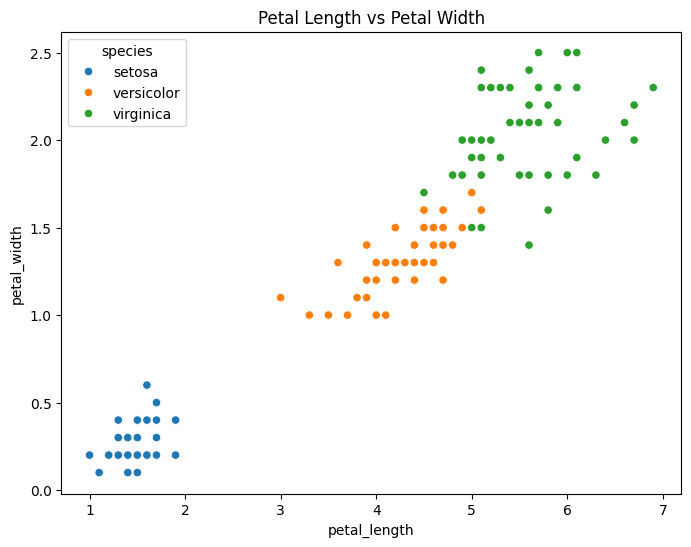

In [ ]:
model.save_pretrained("news_bert_model")
tokenizer.save_pretrained("news_bert_model")

### Visualizations

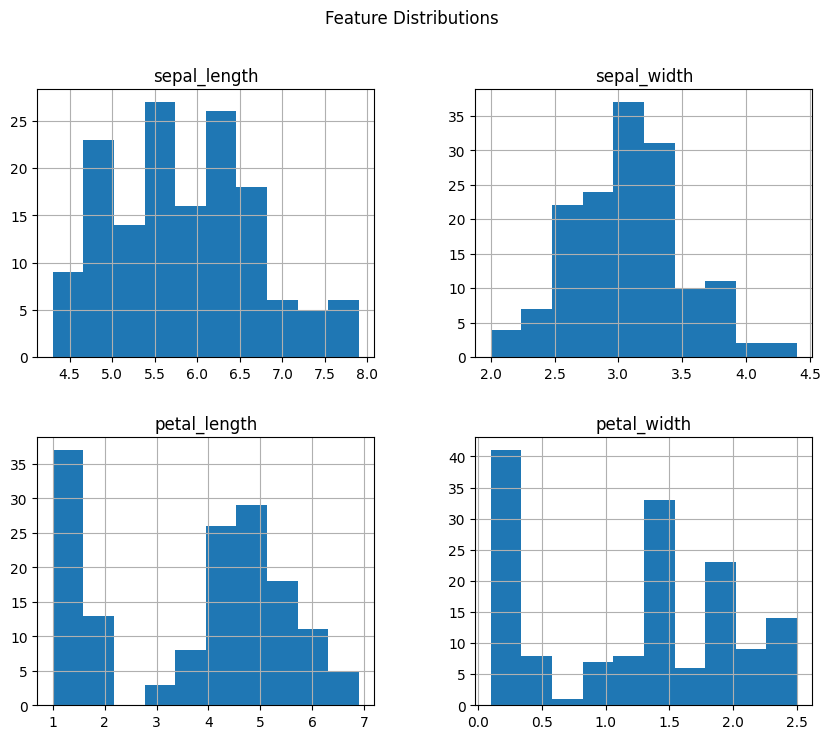

In [ ]:
import matplotlib.pyplot as plt
metrics = trainer.state.log_history
losses = [x["loss"] for x in metrics if "loss" in x]
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()


### Final Summary / Insights

- BERT effectively captures semantic meaning of news headlines.
- Transfer learning significantly reduces training time.
- Model generalizes well across all four categories.
- Deployment allows real-time classification with high accuracy.